In [139]:
import glob
import re
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.linear_model import LogisticRegression
import torch

In [149]:
# 读数据
def readData(pathDir):
    file_list = glob.glob(pathDir)
    img_list = []
    img_labels = []
    for filename in file_list:
        filename_file = re.search("s[0-9]{1,3}.bmp", filename)[0]
        filename_order = re.search("[0-9]{1,3}", filename_file)[0]
        img_labels.append(int(filename_order) // 11)
        img = cv2.imread(filename)
        img_list.append(img)
        
    img_list = np.array(img_list)
    img_labels = np.array(img_labels)

    return img_list, img_labels

In [150]:
# 洗牌
def shuffleData(img_list, img_labels):
    index = [_ for _ in range(len(img_list))]
    np.random.shuffle(index)
    img_list=img_list[index]
    img_labels=img_labels[index]
    
    return img_list, img_labels

In [151]:
# 提取数据的HOG特征
def getHogFeature(img_list, img_labels):
    
    hog_func = lambda x:hog(x, orientations=8, pixels_per_cell=(16, 16), block_norm='L2-Hys',
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
    x_all = np.array([hog_func(img)[0] for img in img_list])
    y_all = np.array(img_labels)
    
    return x_all, y_all

In [152]:
# 将数据集划分为训练集、测试集
def split_data(x_all, y_all, split_rate = 0.8):
    
    total_data_len = len(x_all)

    x_train = x_all[:int(total_data_len*split_rate)]
    y_train = y_all[:int(total_data_len*split_rate)]

    x_test = x_all[int(total_data_len*split_rate):]
    y_test = y_all[int(total_data_len*split_rate):]

    return x_train, y_train, x_test, y_test

In [153]:
# 模型评估
def evluate_specific(model, x, y):
    output = model.predict_proba(x)
    for idx, item in enumerate(output):
        pre = np.argmax(item)
        gt = y[idx]
        print("prediction:{} groundtruth:{}  {}".format(pre, gt, "correct" if pre==gt else "wrong") ) 
        print("---------")
    print("scores：{}".format(model.score(x, y)))

In [163]:
def run(x_all, y_all):
    
    x_train, y_train, x_test, y_test = split_data(x_all, y_all)
    
    model = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial',max_iter=200)
    model.fit(x_train, y_train)
    print("scores：{}".format(model.score(x_test, y_test)))
    
#     evluate_specific(model, x_test, y_test)
    
    return model

In [243]:
# 搜索最优split
def search_best_split(x_all, y_all):
    acc_list = []
    split_rate_list = []
    for i in range(100):
        split_rate = i/10.0
        x_train, y_train, x_test, y_test = split_data(x_all, y_all, split_rate)
        
        if(len(x_train)==0 or len(x_test)==0):
            continue
            
        model = LogisticRegression(random_state=1, solver='lbfgs', multi_class='multinomial',max_iter=200)
        model.fit(x_train, y_train)
        print(split_rate)
        score = model.score(x_test, y_test)
        print("scores：{}".format(score))
        print("------")
        
        acc_list.append(score)
        split_rate_list.append(split_rate)
    return acc_list, split_rate_list

In [275]:
img_list,img_labels = readData("./data/*.bmp")
img_list,img_labels = shuffleData(img_list, img_labels)
x_all, y_all = getHogFeature(img_list, img_labels)

In [276]:
run(x_all, y_all)

scores：0.9090909090909091


LogisticRegression(max_iter=200, multi_class='multinomial', random_state=1)

In [277]:
acc_list, split_rate_list = search_best_split(x_all, y_all)

0.1
scores：0.3087248322147651
------
0.2
scores：0.4090909090909091
------
0.3
scores：0.603448275862069
------
0.4
scores：0.7676767676767676
------
0.5
scores：0.8192771084337349
------
0.6
scores：0.8939393939393939
------
0.7
scores：0.9
------
0.8
scores：0.9090909090909091
------
0.9
scores：0.9411764705882353
------


In [278]:
import matplotlib.pyplot as plt
def display_training_curves(acc_list, split_rate_list, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(split_rate_list, acc_list)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('split_rate')
    ax.legend([title])
#     plt.xticks(split_rate_list)

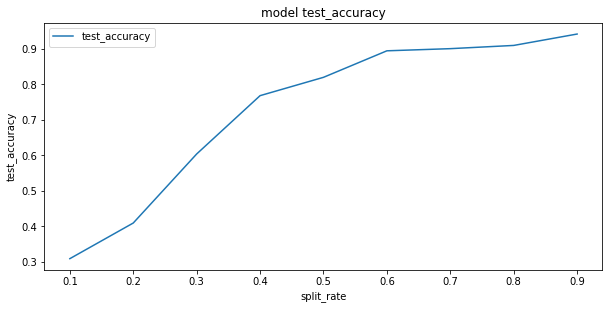

In [279]:
plt.subplots(figsize=(10,10))
display_training_curves(acc_list, split_rate_list, 'test_accuracy', 211)

# HOG 特征提取（不调库）

In [179]:
import glob
import re
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
import torch
from skimage import color

In [180]:
def conv(img, is_hori = True):
    if(is_hori):
        conv_kernal = [[-1, 0, 1]]
    else:
        conv_kernal = [[-1],[0],[1]]
    conv_kernal = np.array(conv_kernal, dtype="float32")
    return cv2.filter2D(img, -1, conv_kernal)

In [181]:
def gamma(img):
    return np.sqrt(img)

In [182]:
def calGxy(gx, gy):
    return np.sqrt(gx**2 + gy**2)

In [183]:
def calThetaxy(gx, gy):
    return np.array([[np.pi/2 if np.isnan(iitem) else iitem for iitem in item] for item in np.arctan(gy/gx)], dtype="float32") + np.pi/2

In [184]:
def calGaT(img):
    gx = conv(img,True)
    gy = conv(img,False)
    gxy = calGxy(gx,gy)
    txy = calThetaxy(gx, gy)
#     plt.imshow(gxy, cmap = plt.cm.gray)
    return gxy, txy

In [185]:
def get_color_hist(img, gxy, txy, ori=9):
    per_bin = np.pi/ori
    hist = [0.0 for _ in range(ori)]
    for i in range(len(img)):
        for j in range(len(img[i])):
            idx = abs(int(txy[i][j]/per_bin))
            hist[idx % ori] += (txy[i][j] - idx*per_bin)*gxy[i][j]
            hist[(idx+1) % ori] += (((idx+1))*per_bin - txy[i][j])*gxy[i][j]
    return hist

In [186]:
def get_cell_hist(img, gxy, txy, cell=(8, 8), ori=9):
    total_cell_hist = []
    x, y = cell
    w, h = img.shape
    per_x = w/x
    per_y = h/y
    for i in range(x):
        total_cell_hist_x = []
        for j in range(y):
            img_cell = img[int(i*per_x):int((i+1)*per_x), int(j*per_y):int((j+1)*per_y)]
            gxy_cell = gxy[int(i*per_x):int((i+1)*per_x), int(j*per_y):int((j+1)*per_y)]
            txy_cell = txy[int(i*per_x):int((i+1)*per_x), int(j*per_y):int((j+1)*per_y)]
            total_cell_hist_x.append(get_color_hist(img_cell, gxy_cell, txy_cell, ori))
        total_cell_hist.append(total_cell_hist_x)
    return np.array(total_cell_hist, dtype="float32")

In [258]:
def get_block_hist(img, gxy, txy, per_block = 4, cell=(8, 8), ori=9):
    total_cell_hist = get_cell_hist(img, gxy, txy, cell, ori)
    x, y = cell
    total_block_hist = []
    for i in range(x-1):
        for j in range(y-1):
            total_block_hist.append(
                np.concatenate([
                                total_cell_hist[i][j],
                                total_cell_hist[i+1][j],
                                total_cell_hist[i][j+1],
                                total_cell_hist[i+1][j+1]
                               ])
            )

    return np.array(total_block_hist, dtype="float32")

In [270]:
def getImgFeature(img):
    img = gamma(img)
    gxy, txy = calGaT(img)
    total_cell_hist = get_block_hist(img, gxy, txy, 4, cell=(8, 8), ori = 9)
    total_cell_hist_norm = []
    for item in total_cell_hist:
        total_cell_hist_norm.append(item/np.linalg.norm(item))
    total_cell_hist_norm = np.array(total_cell_hist_norm)
    
    return total_cell_hist_norm

In [271]:
img_list,img_labels = readData("./data/*.bmp")

img_list,img_labels = shuffleData(img_list, img_labels)

# plt.imshow(img_list[0])

img_list = np.array([color.rgb2gray(img) for img in img_list], dtype="float32")

x_all = np.array([getImgFeature(img)[0].reshape(-1) for img in img_list])
y_all = np.array(img_labels)

<ipython-input-183-73a0d6465bca>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.array([[np.pi/2 if np.isnan(iitem) else iitem for iitem in item] for item in np.arctan(gy/gx)], dtype="float32") + np.pi/2
<ipython-input-183-73a0d6465bca>:2: RuntimeWarning: invalid value encountered in true_divide
  return np.array([[np.pi/2 if np.isnan(iitem) else iitem for iitem in item] for item in np.arctan(gy/gx)], dtype="float32") + np.pi/2


In [272]:
acc_list, split_rate_list = search_best_split(x_test, y_test)

0.1
scores：0.06666666666666667
------
0.2
scores：0.14814814814814814
------
0.3
scores：0.125
------
0.4
scores：0.25
------
0.5
scores：0.23529411764705882
------
0.6
scores：0.42857142857142855
------
0.7
scores：0.4
------
0.8
scores：0.42857142857142855
------
0.9
scores：0.25
------


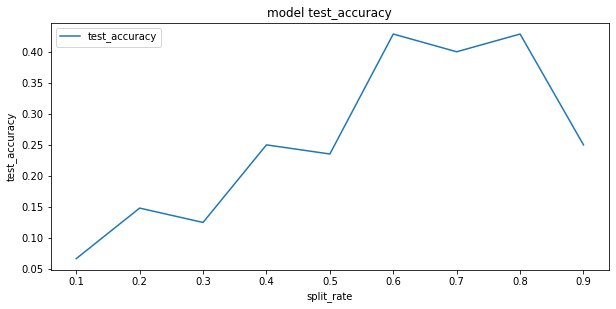

In [273]:
plt.subplots(figsize=(10,10))
display_training_curves(acc_list, split_rate_list, 'test_accuracy', 211)

##### 手写的HOG估计哪儿写的有点问题，或者是参数没有调好，导致性能很一般